# Identification of authorized vs unauthorized vehicles

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Car Number Plate Authorization using VGG16 and SVM models

### Load VGG16 Model and predict Car Number Plate detection

In [46]:
from keras.models import model_from_json
# load json and create model
json_file = open('/content/drive/My Drive/AIML/GL AIML Capstone/Final/Code/VGG16 & SVM Model/Car_Number_Plate_Detection_VGG16_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/content/drive/My Drive/AIML/GL AIML Capstone/Final/Code/VGG16 & SVM Model/Car_Number_Plate_Detection_VGG16_model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


[ 41.50854  93.50998 183.31934 130.68219]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


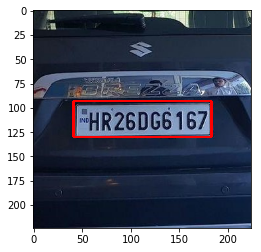

Car image shape: (224, 224, 3)


In [47]:
import cv2
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# working images
# licensed_car82.jpeg, licensed_car213.jpeg, licensed_car224.jpeg, licensed_car238.jpeg,licensed_car217.jpeg
# % accuracy - licensed_car80,licensed_car253.jpeg, licensed_car264.jpeg, licensed_car505.jpeg
img_name = '/content/drive/My Drive/AIML/GL AIML Capstone/Final/Data/Car Annotated Images/licensed_car264.jpeg'

img = cv2.imread(img_name)
img = cv2.resize((img) / 255.0, dsize=(224, 224))

y_hat = model.predict(img.reshape(1, 224, 224, 3)).reshape(-1) * 224
print(y_hat)

xt, yt = y_hat[0], y_hat[1]
xb, yb = y_hat[2], y_hat[3]
    
xti = int(xt)
xbi = int(xb)
yti = int(yt)
ybi = int(yb)
    
car_image = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
Number_plate_bbox = cv2.rectangle(car_image, (xti, yti), (xbi, ybi), (255, 0, 0), 2) 
plt.imshow(Number_plate_bbox)
plt.show()

print('Car image shape:',car_image.shape)

#Assigning the number plate bounding box co-ordinates to variables
Number_plate_bbox_xmin = int(xt)
Number_plate_bbox_xmax = int(xb)
Number_plate_bbox_ymin = int(yt)
Number_plate_bbox_ymax = int(yb)

### Car Number Plate character recognition

In [0]:
from skimage.io import imread
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from skimage import measure
from skimage.measure import regionprops
import matplotlib.patches as patches


### Taking VGG16 output as input for Character recognition

In [49]:
print('Number_plate_bbox_xmin:',Number_plate_bbox_xmin)
print('Number_plate_bbox_xmax:',Number_plate_bbox_xmax)
print('Number_plate_bbox_ymin:',Number_plate_bbox_ymin)
print('Number_plate_bbox_ymax:',Number_plate_bbox_ymax)

Number_plate_bbox_xmin: 41
Number_plate_bbox_xmax: 183
Number_plate_bbox_ymin: 93
Number_plate_bbox_ymax: 130


In [50]:
car_image_orig = imread(img_name,as_gray=True)
print(car_image_orig.shape)

car_image = resize(car_image_orig, (224, 224))
print(car_image.shape)

(336, 335)
(224, 224)


### Converting the image to Grey and Binary scale

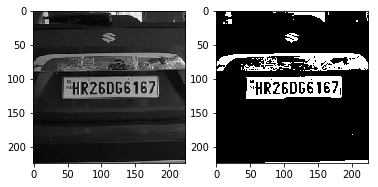

In [51]:
gray_car_image = car_image * 255
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gray_car_image, cmap="gray")
threshold_value = threshold_otsu(gray_car_image)
binary_car_image = gray_car_image > threshold_value
ax2.imshow(binary_car_image, cmap="gray")
plt.show()

### Using number plate bbox co-ordinates generated from VGG16 model

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False  True ...  True False  True]
 [False False False ...  True  True  True]
 [False False False ... False False False]]
(93, 41, 130, 183)


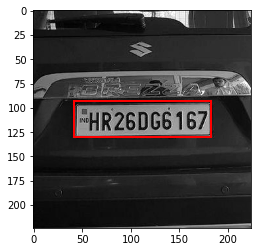

In [52]:
plate_objects_cordinates = []
plate_like_objects = []
fig, (ax1) = plt.subplots(1)
ax1.imshow(gray_car_image, cmap="gray");

plate_like_objects.append(binary_car_image[Number_plate_bbox_ymin:Number_plate_bbox_ymax,Number_plate_bbox_xmin:Number_plate_bbox_xmax])
print(plate_like_objects[0])

plate_objects_cordinates.append((Number_plate_bbox_ymin, Number_plate_bbox_xmin, Number_plate_bbox_ymax, Number_plate_bbox_xmax))
print(plate_objects_cordinates[0])

rectBorder = patches.Rectangle((Number_plate_bbox_xmin, Number_plate_bbox_ymin), Number_plate_bbox_xmax-Number_plate_bbox_xmin, Number_plate_bbox_ymax-Number_plate_bbox_ymin, edgecolor="red", linewidth=2, fill=False)

ax1.add_patch(rectBorder)
plt.show()

### Segregating the number plate and creating bounding box for each character

License Plate Height: 37
License Plate Width : 142
min_height: 7
max_height: 27
min_width: 2
max_width: 28


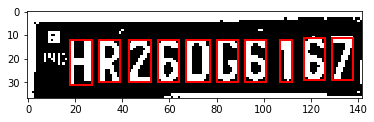

In [53]:
license_plate = np.invert(plate_like_objects[0])
# license_plate = (plate_like_objects[0])
print('License Plate Height:',license_plate.shape[0])
print('License Plate Width :',license_plate.shape[1])

labelled_plate = measure.label(license_plate)
# print(labelled_plate)

fig, ax1 = plt.subplots(1)
ax1.imshow(license_plate, cmap="gray")
 
character_dimensions = (int(0.2 *license_plate.shape[0]),
                        int(0.75 *license_plate.shape[0]),
                        int(0.02*license_plate.shape[1]), 
                        int(0.2 *license_plate.shape[1])
                       )

min_height, max_height, min_width, max_width = character_dimensions

print('min_height:',min_height)
print('max_height:',max_height)
print('min_width:',min_width)
print('max_width:',max_width)

characters = []
counter=0
column_list = []
for regions in regionprops(labelled_plate):
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0

    if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
        roi = license_plate[y0:y1, x0:x1]

        # draw a red bordered rectangle over the character.
        rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",
                                       linewidth=2, fill=False)
        ax1.add_patch(rect_border)

        # resize the characters to 20X20 and then append each character into the characters list
        resized_char = resize(roi, (20, 20))
        characters.append(resized_char)

        # this is just to keep track of the arrangement of the characters
        column_list.append(x0)

plt.show()

In [0]:
# !pip install joblib

### Loading SVM Model for character recognition

In [55]:
# load the model
current_dir = '/content/drive/My Drive/AIML/GL AIML Capstone/Final/Code/VGG16 & SVM Model/'
model_dir = current_dir+ 'Car_Number_Plate_Char_Recog_SVM_Model.pkl'
model = joblib.load(model_dir)

classification_result = []
for each_character in characters:
    # converts it to a 1D array
    each_character = each_character.reshape(1, -1);
    result = model.predict(each_character)
    classification_result.append(result)

print(classification_result)

plate_string = ''
for eachPredict in classification_result:
    plate_string += eachPredict[0]

print(plate_string)

# it's possible the characters are wrongly arranged
# since that's a possibility, the column_list will be
# used to sort the letters in the right order

column_list_copy = column_list[:]
column_list.sort()
rightplate_string = ''
for each in column_list:
    rightplate_string += plate_string[column_list_copy.index(each)]

print(rightplate_string)


[array(['6'], dtype='<U1'), array(['7'], dtype='<U1'), array(['H'], dtype='<U1'), array(['R'], dtype='<U1'), array(['2'], dtype='<U1'), array(['6'], dtype='<U1'), array(['D'], dtype='<U1'), array(['G'], dtype='<U1'), array(['6'], dtype='<U1'), array(['1'], dtype='<U1')]
67HR26DG61
HR26DG6167
